In [31]:
import wfdb
import numpy as np
from wfdb import processing

In [68]:
class HeartbeatSlicer:
    def __init__(self, record_path, sampfrom=0, sampto=None, num_heartbeats=3):
        self.record = wfdb.rdrecord(record_name=record_path, sampfrom=sampfrom, sampto=sampto)
        self.annotations = wfdb.rdann(record_name=record_path, extension='atr', sampfrom=sampfrom, sampto=sampto, shift_samps=True)
        self.ann_symbols = self.annotations.symbol
        self.ecg_data = self.record.p_signal[:, 0]
        self.sampling_rate = self.record.fs
        self.peak_indices = self.detect_peaks()
        self.num_heartbeats = num_heartbeats
        self.label_dict = {
         # Normal Beats (Non-Arrhythmia):
            #     N: Normal beat
            #     /: Paced beat (This is considered normal when a patient has a pacemaker)
        'N': 0, '/': 0,

        # Supraventricular Arrhythmias:
            #     A: Atrial premature beat
            #     a: Aberrated atrial premature beat
            #     S: Supraventricular premature or ectopic beat (atrial or nodal)
            #     e: Atrial escape beat
            #     n: Supraventricular escape beat (atrial or nodal)
        'A': 1, 'a': 1, 'S': 1, 'e': 1, 'n': 1,

        # Ventricular Arrhythmias:
            #     V: Premature ventricular contraction
            #     r: R-on-T premature ventricular contraction
            #     E: Ventricular escape beat
            #     F: Fusion of ventricular and normal beat
        'V': 2, 'r': 2, 'E': 2, 'F': 2,

        # Conduction Problems (Bundle Branch Blocks):
            #     L: Left bundle branch block beat
            #     R: Right bundle branch block beat
            #     B: Bundle branch block beat (unspecified)
        'L': 3, 'R': 3, 'B': 3,

        # Junctional Rhythms:
            #     J: Nodal (junctional) premature beat
            #     j: Nodal (junctional) escape beat
        'J': 4, 'j': 4,
        # Paced Rhythms:
            #     f: Fusion of paced and normal beat
        'f': 5,
        # Unclassifiable/Other Beats:
            #     Q: Unclassifiable beat
            #     ?: Beat not classified during learning
        'Q': 6, '?': 6}


    def detect_peaks(self):
        """
        Detects peaks in the ECG data.

        Returns: numpy array with the indices of peaks.
        """

        # peak_indices = processing.gqrs_detect(sig=self.ecg_data, fs=self.sampling_rate)

        peak_indices = self.annotations.sample

        return np.array(peak_indices, dtype=object)

    def slice_heartbeats(self):
        """
        Slice the ECG data into sequences of a fixed number of consecutive heartbeats.

        num_heartbeats : The number of consecutive heartbeats to include in each sequence.

        Returns: 2D numpy array, each row is a sequence of heartbeats.
        """
        heartbeats = []

        for i in range(self.num_heartbeats, len(self.peak_indices)-self.num_heartbeats):
            start = self.peak_indices[i] - (self.peak_indices[i] - self.peak_indices[i-self.num_heartbeats])//2
            end = self.peak_indices[i] +  (self.peak_indices[i+self.num_heartbeats] - self.peak_indices[i])//2
            sequence = self.ecg_data[start:end]

            heartbeats.append(sequence)

        return np.array(heartbeats, dtype=object)
        # return heartbeats


    def annotate_heartbeats(self):
        """
        Annotates the heartbeats obtained from the slice_heartbeats() method. It assigns labels to each heartbeat based on the provided label dictionary. The labels are added to the heartbeats array as a new column.

        Returns: numpy.ndarray: The annotated heartbeats array with the labels added as a new column.

        """
        heartbeats = self.slice_heartbeats()

        anns = list(map(lambda x: self.label_dict.get(x, x), self.ann_symbols[self.num_heartbeats:-self.num_heartbeats]))

        return np.column_stack((heartbeats, anns))




In [69]:
testMitdb = HeartbeatSlicer("data_processed/mitdb/100_processed").annotate_heartbeats()
testNsrb = HeartbeatSlicer("data_processed/nsrdb/16265_processed").annotate_heartbeats()
testSvdb = HeartbeatSlicer("data_processed/svdb/800_processed").annotate_heartbeats()

In [70]:
from matplotlib import pyplot as plt

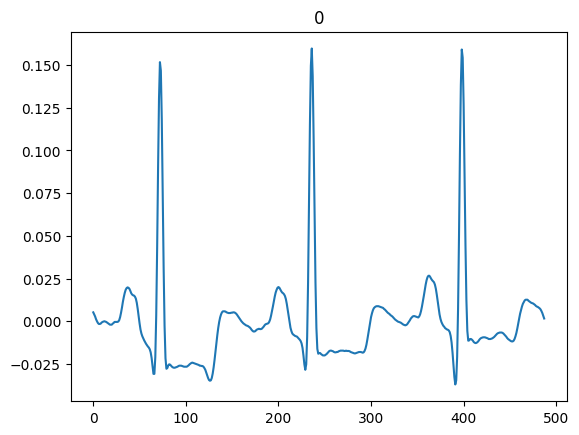

In [71]:
# plt.plot(testMitdb[233][0])
# plt.title(testMitdb[35][1])
# plt.show()

# for (signal, ann) in testNsrb:
#     if not isinstance(ann, int):
#         plt.plot(signal)
#         plt.title(ann)
#         plt.show()



# plt.plot(testSvdb[1001][0])
# plt.title(testSvdb[35][1])
# plt.show()
#
# plt.plot(testNsrb[727][0])
# plt.title(testNsrb[35][1])
# plt.show()

In [60]:
testMitdb[0][0]

array([-0.01220739, -0.01600969, -0.02121284, -0.02621587, -0.02761672,
       -0.02021224,  0.00060036,  0.03722254,  0.08545174,  0.13508179,
        0.1721042 ,  0.18551232,  0.17130372,  0.13448142,  0.08625222,
        0.03982411,  0.00500303, -0.01460885, -0.02181321, -0.02201333,
       -0.02041236, -0.01941175, -0.01921163, -0.01961187, -0.02021224,
       -0.02061248, -0.0208126 , -0.02061248, -0.02041236, -0.02041236,
       -0.02041236, -0.02061248, -0.02101272, -0.02141296, -0.02181321,
       -0.02221345, -0.02241357, -0.02241357, -0.02221345, -0.02161309,
       -0.02101272, -0.02041236, -0.02001212, -0.01961187, -0.01921163,
       -0.01901151, -0.01901151, -0.01881139, -0.01901151, -0.01921163,
       -0.01961187, -0.02021224, -0.0208126 , -0.02141296, -0.02221345,
       -0.02301393, -0.02381442, -0.0246149 , -0.02561551, -0.02661612,
       -0.02761672, -0.02861733, -0.02961793, -0.03061854, -0.03141902,
       -0.03221951, -0.03261975, -0.03261975, -0.03201939, -0.03

In [61]:
np.unique(testMitdb[:, 1], return_counts=True)

(array([0, 1, 2], dtype=object), array([2234,   33,    1]))

In [46]:
np.unique(testSvdb[:, 1], return_counts=True)

(array(['0', '1', '2', '|', '~'], dtype=object),
 array([1840,   30,    7,   10,   28]))

In [47]:
np.unique(testNsrb[:, 1], return_counts=True)


(array(['0', '1', '2', '|', '~'], dtype=object),
 array([100211,      5,     22,    258,    453]))